In [1]:
#import Library
import os
import xarray as xr
import rioxarray as rxr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

#### Stack all dataset

In [11]:
def stack_lst_ndvi(data_folder):
    # Search for all .tif files in the specified folder
    file_paths = glob(os.path.join(data_folder, "*.tif"))
    
    all_years = []
    
    for path in file_paths:
        # Extract the year from the filename (assuming format like "file_2015.tif")
        file_name = os.path.basename(path)
        year = int(file_name.split('_')[-1].split('.')[0])

        # Open the multi-band raster
        da = rxr.open_rasterio(path, masked=True)
        
        # Split the bands into separate variables
        # Band 1: Land Surface Temperature (LST)
        # Band 2: Normalized Difference Vegetation Index (NDVI)
        lst = da.sel(band=1).drop_vars("band")
        ndvi = da.sel(band=2).drop_vars("band")
        
        # Create a single Dataset for this specific year
        # We assign a specific date for this actually i used composite data from aug-sep
        ds_year = xr.Dataset(
            data_vars={
                'lst': lst,
                'ndvi': ndvi
            },
            coords={'time': pd.to_datetime(f"{year}-08-01")} # Adjust month/day as needed
        )
        
        all_years.append(ds_year)

    # Concatenate all annual datasets along the time dimension
    ds = xr.concat(all_years, dim='time').sortby('time')
    
    # Add metadata attributes reflecting the study methodology [cite: 77, 78, 92]
    ds.attrs.update({
        'description': 'Multi-year stack of LST and NDVI for drought assessment',
        'source': 'Landsat 8 OLI/TIRS',
        'location': 'Jeneponto, Indonesia'
    })
    
    # Summary Output
    print(f"Successfully stacked {len(file_paths)} years of data.")
    print(f"Bands: {list(ds.data_vars)}")
    print(f"Time range: {ds.time.dt.year.min().values} - {ds.time.dt.year.max().values}")
    
    return ds

In [12]:
data_folder = r"D:\Project\drought\Data Raster\clip_lst_ndvi"
dataset = stack_lst_ndvi(data_folder)

Successfully stacked 10 years of data.
Bands: ['lst', 'ndvi']
Time range: 2015 - 2024


#### Visualization of LST and NDVI

In [13]:
lst_ndvi_dataset = dataset.sortby('time')

<Figure size 700x400 with 0 Axes>

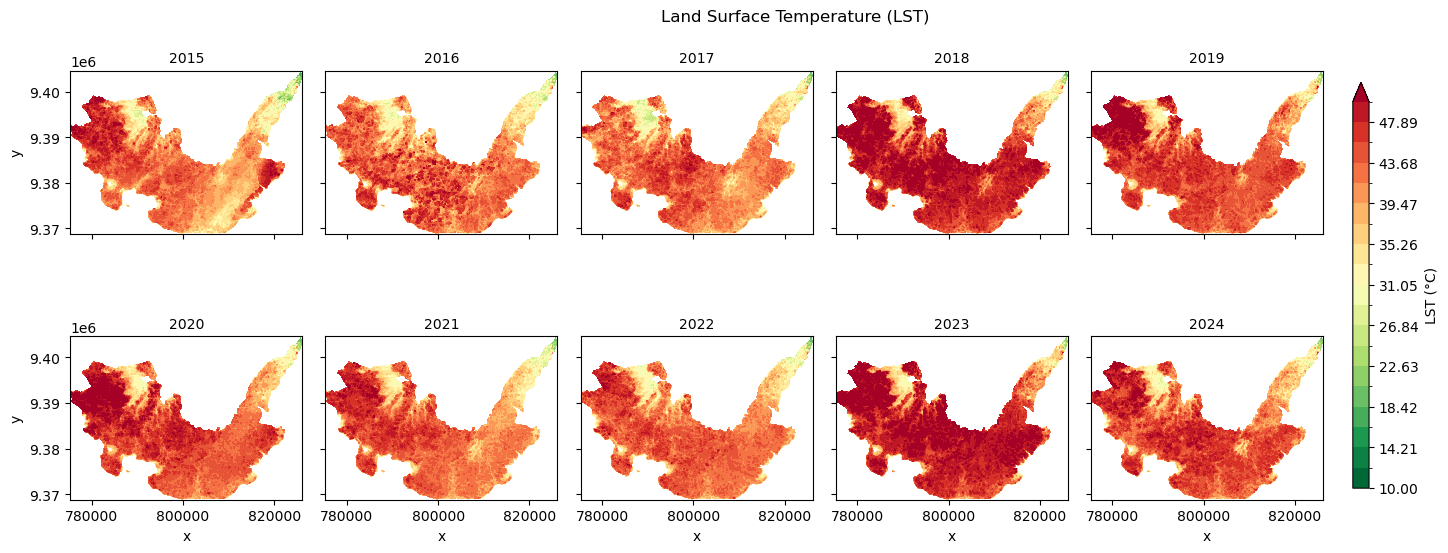

In [ ]:
# Determine the figure size at the beginning
fig = plt.figure(figsize=(7, 4)) 

vis_lst = lst_ndvi_dataset.lst.assign_coords(time=lst_ndvi_dataset.time.dt.year).plot.contourf(
    x = 'x',
    y = 'y',
    col = 'time',
    col_wrap = 5,
    robust = True,
    cmap = 'RdYlGn_r',
    vmin = 10,
    vmax = 50,
    levels = 20,
    add_colorbar = True,
    cbar_kwargs = {"shrink": 0.8, "aspect": 25, "label": "LST (°C)"}
)

for ax in vis_lst.axs.flat:
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)

vis_lst.fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.83)
vis_lst.set_titles("{value}")

plt.suptitle('Land Surface Temperature (LST)', y=0.98)
plt.show()

<Figure size 700x400 with 0 Axes>

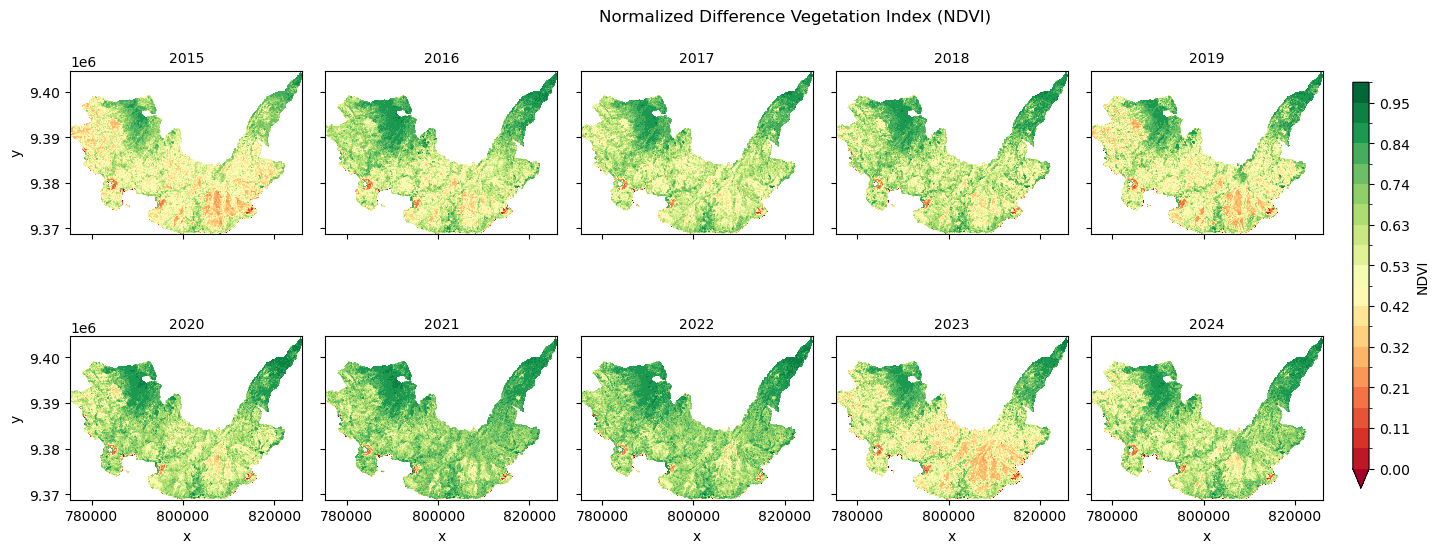

In [15]:
# Determine the figure size at the beginning
fig = plt.figure(figsize=(7, 4)) 

vis_lst = lst_ndvi_dataset.ndvi.assign_coords(time=lst_ndvi_dataset.time.dt.year).plot.contourf(
    x = 'x',
    y = 'y',
    col = 'time',
    col_wrap = 5,
    robust = True,
    cmap = 'RdYlGn', #revresed
    vmin = 0,
    vmax = 1,
    levels = 20,
    add_colorbar = True,
    cbar_kwargs = {"shrink": 0.8, "aspect": 25, "label": "NDVI", "format":"%.2f"}
)

for ax in vis_lst.axs.flat:
    ax.set_aspect('equal', adjustable='box')
    ax.grid(False)

vis_lst.fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.83)
vis_lst.set_titles("{value}")

plt.suptitle('Normalized Difference Vegetation Index (NDVI)', y=0.98)
plt.show()

#### Culculate Temperature condition index (TCI)

TCI = (LSTmax - LST) / (LSTmax - LSTmin)

In [ ]:
#culculate trmm min and max
lst_ds = lst_ndvi_dataset.lst.sortby('time')

lst_max = lst_ds.max(dim='time')
lst_min = lst_ds.min(dim='time')
print(f'lst_max {lst_max.max().values:.2f}°C')
print(f'lst_min {lst_min.min().values:.2f}°C')

lst_max 62.17°C
lst_min 12.98°C


In [22]:
#tci formula
tci = (lst_max- lst_ds)/(lst_max-lst_min)

In [ ]:
# Define the list of years for calculation (from 2015 to 2024)
years = [str(y) for y in range(2015, 2025)]

# Dictionary to store the statistical results (optional)
pci_stats = {}

for year in years:
    # Select the PCI data for a specific year and remove single-dimensional entries
    tci_year = tci.sel(time=year).squeeze()
    
    # Calculate pixel-based statistics for the selected year
    min_val = tci_year.min().item()
    max_val = tci_year.max().item() 
    avg_val = tci_year.mean().item() 
    
    # Store the results in the dictionary
    pci_stats[year] = {'min': min_val, 'max': max_val, 'mean': avg_val}
    
    # Print the summary for each year
    print(f"Year {year} | Min: {min_val:.4f}, Max: {max_val:.4f}, Mean: {avg_val:.4f}")

In [24]:
# Example: Save a specific year's map to a GeoTIFF file (e.g., for the year 2015)
tci.sel(time='2015').squeeze().rio.write_crs('EPSG:32750', inplace=True).rio.to_raster("TCI_Jeneponto_2015.tif")

#### Culculate Vegetation condition index (VCI) 

TCI = (NDVI - NDVImin) / (NDVImax - NDVImin)

In [25]:
#culculate trmm min and max
ndvi_ds = lst_ndvi_dataset.ndvi.sortby('time')

ndvi_max = ndvi_ds.max(dim='time')
ndvi_min = ndvi_ds.min(dim='time')
print(f'ndvi_max {ndvi_max.max().values:.2f}')
print(f'ndvi_min {ndvi_min.min().values:.2f}')

ndvi_max 0.99
ndvi_min -0.98


In [26]:
#vci formula
vci = (ndvi_ds-ndvi_min)/(ndvi_max-ndvi_min)

In [ ]:
# Define the list of years for calculation (from 2015 to 2024)
years = [str(y) for y in range(2015, 2025)]

# Dictionary to store the statistical results (optional)
vci_stats = {}

for year in years:
    # Select the PCI data for a specific year and remove single-dimensional entries
    vci_year = vci.sel(time=year).squeeze()
    
    # Calculate pixel-based statistics for the selected year
    min_val = vci_year.min().item()
    max_val = vci_year.max().item() 
    avg_val = vci_year.mean().item() 
    
    # Store the results in the dictionary
    pci_stats[year] = {'min': min_val, 'max': max_val, 'mean': avg_val}
    
    # Print the summary for each year
    print(f"Year {year} | Min: {min_val:.4f}, Max: {max_val:.4f}, Mean: {avg_val:.4f}")

In [28]:
# Example: Save a specific year's map to a GeoTIFF file (e.g., for the year 2015)
vci.sel(time='2015').squeeze().rio.write_crs('EPSG:32750', inplace=True).rio.to_raster("VCI_Jeneponto_2015.tif")